In [1]:
!pip install geocoder
!pip install folium

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [5]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [6]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [7]:
df.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2NNorth York(Willowdale)South\n\n,M9NYork(Weston)
freq,1,1,1


In [8]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [9]:
df.head()

,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [10]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [11]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,20,20,20
unique,20,20,20
top,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2NNorth York(Willowdale)South\n\n,M9NYork(Weston)
freq,1,1,1


In [12]:
print(df_2.shape)
df_2.head()

(20, 3)


,Postalcode,Borough,Neighborhood
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue)
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned


In [13]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [14]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [15]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [16]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [17]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.648690,-79.385440
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.810230,-79.220380
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.787160,-79.132520
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned,43.749530,-79.189920
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned,43.767480,-79.228290
5,\nM1HScarborough(Cedarbrae)\n\n,\nM2HNorth York(Hillcrest Village)\n\n,M9HNot assigned,43.741679,-79.232559
6,\nM1JScarborough(Scarborough Village)\n\n,\nM2JNorth York(Fairview / Henry Farm / Oriole...,M9JNot assigned,43.738650,-79.216990
7,\nM1KScarborough(Kennedy Park / Ionview / East...,\nM2KNorth York(Bayview Village)\n\n,M9KNot assigned,43.725870,-79.262290
8,\nM1LScarborough(Golden Mile / Clairlea / Oakr...,\nM2LNorth York(York Mills / Silver Hills)\n\n,M9LNorth York(Humber Summit),43.698830,-79.279120
9,\nM1MScarborough(Cliffside / Cliffcrest / Scar...,\nM2MNorth York(Willowdale / Newtonbrook)\n\n,M9MNorth York(Humberlea / Emery),43.726420,-79.232970


In [21]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


In [22]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [24]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [25]:
# @hiddel_cell
CLIENT_ID = '2THQDGWGGWXYNN55PYPX21KVH3YIN1SXAWZE3XAWZWZZESZR' # my Foursquare ID
CLIENT_SECRET = 'SQ4ZVE40CNL2TOM23C53XXDH13FFNQIDNRZS10JNPOC2BKGO' # my Foursquare Secret
VERSION = '20210325'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2THQDGWGGWXYNN55PYPX21KVH3YIN1SXAWZE3XAWZWZZESZR
CLIENT_SECRET: SQ4ZVE40CNL2TOM23C53XXDH13FFNQIDNRZS10JNPOC2BKGO


In [26]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [27]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [28]:

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
2,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775512,-79.258288
3,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662
4,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369


In [30]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,American Eagle Store,Clothing Store,43.776012,-79.258334
2,SEPHORA,Cosmetics Shop,43.775512,-79.258288
3,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662
4,Tommy Hilfiger,Clothing Store,43.776015,-79.257369


In [31]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      9
Restaurant          5
Coffee Shop         4
Women's Store       2
Pharmacy            2
Department Store    2
Sandwich Place      2
Cosmetics Shop      2
Gas Station         2
Intersection        2
Name: categories, dtype: int64

In [32]:
 
def getNearbyVenues(names, latitudes, longitudes, radius=700):   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:

# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

M9AEtobicoke(Islington Avenue)
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood)
M9ENot assigned
M9GNot assigned
M9HNot assigned
M9JNot assigned
M9KNot assigned
M9LNorth York(Humber Summit)
M9MNorth York(Humberlea / Emery)
M9NYork(Weston)
M9PEtobicoke(Westmount)
M9REtobicoke(Kingsview Village / St. Phillips / Martin Grove Gardens / Richview Gardens)
M9SNot assigned
M9TNot assigned
M9VEtobicoke(South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens)
M9WEtobicokeNorthwest(Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)
M9XNot assigned
M9YNot assigned
M9ZNot assigned


In [34]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 109 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
M9AEtobicoke(Islington Avenue),100,100,100,100,100,100
M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale),15,15,15,15,15,15
M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood),5,5,5,5,5,5
M9ENot assigned,3,3,3,3,3,3
M9GNot assigned,5,5,5,5,5,5


In [35]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Big Box Store,Bistro,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Bus Stop,Butcher,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Electronics Store,Fast Food Restaurant,Fish Market,Food Court,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hong Kong Restaurant,Hookah Bar,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Neighborhood,New American Restaurant,Park,Pharmacy,Pizza Place,Plaza,Poke Place,Pub,Record Shop,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shopping Mall,Skating Rink,Smoke Shop,Soup Place,Souvlaki Shop,Speakeasy,Steakhouse,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M9AEtobicoke(Islington Avenue),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- M9AEtobicoke(Islington Avenue) ----
                 venue  freq
0          Coffee Shop  0.12
1                Hotel  0.06
2                 Café  0.06
3  Japanese Restaurant  0.04
4           Restaurant  0.04


---- M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale) ----
                  venue  freq
0  Fast Food Restaurant  0.20
1           Pizza Place  0.13
2              Pharmacy  0.13
3                  Park  0.13
4            Restaurant  0.07


---- M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood) ----
             venue  freq
0         Pharmacy   0.2
1           Bakery   0.2
2             Bank   0.2
3  Thai Restaurant   0.2
4      Supermarket   0.2


---- M9ENot assigned ----
                venue  freq
0               Hotel  0.33
1   Convenience Store  0.33
2                Park  0.33
3  Mexican Restaurant  0.00
4          Poke Place  0.00


---- M9GNot assigned ----
               venue  freq
0  Indian Re

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M9AEtobicoke(Islington Avenue),Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Beer Bar,Concert Hall,Cosmetics Shop,Bookstore,Theater
1,M9BEtobicoke(West Deane Park / Princess Garden...,Fast Food Restaurant,Pharmacy,Pizza Place,Park,Supermarket,Restaurant,Bubble Tea Shop,Sandwich Place,Grocery Store,Skating Rink
2,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,Pharmacy,Thai Restaurant,Supermarket,Bakery,Bank,Electronics Store,Coffee Shop,College Stadium,Comedy Club,Concert Hall
3,M9ENot assigned,Hotel,Park,Convenience Store,Vietnamese Restaurant,Fast Food Restaurant,College Stadium,Comedy Club,Concert Hall,Cosmetics Shop,Deli / Bodega
4,M9GNot assigned,Indian Restaurant,Coffee Shop,Park,Bank,Fast Food Restaurant,College Stadium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop


In [39]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0])

In [40]:

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,\nM1ANot assigned\n\n,\nM2ANot assigned\n\n,M9AEtobicoke(Islington Avenue),43.64869,-79.38544,0,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Beer Bar,Concert Hall,Cosmetics Shop,Bookstore,Theater
1,\nM1BScarborough(Malvern / Rouge)\n\n,\nM2BNot assigned\n\n,M9BEtobicoke(West Deane Park / Princess Garden...,43.81023,-79.22038,0,Fast Food Restaurant,Pharmacy,Pizza Place,Park,Supermarket,Restaurant,Bubble Tea Shop,Sandwich Place,Grocery Store,Skating Rink
2,\nM1CScarborough(Rouge Hill / Port Union / Hig...,\nM2CNot assigned\n\n,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...,43.78716,-79.13252,0,Pharmacy,Thai Restaurant,Supermarket,Bakery,Bank,Electronics Store,Coffee Shop,College Stadium,Comedy Club,Concert Hall
3,\nM1EScarborough(Guildwood / Morningside / Wes...,\nM2ENot assigned\n\n,M9ENot assigned,43.74953,-79.18992,1,Hotel,Park,Convenience Store,Vietnamese Restaurant,Fast Food Restaurant,College Stadium,Comedy Club,Concert Hall,Cosmetics Shop,Deli / Bodega
4,\nM1GScarborough(Woburn)\n\n,\nM2GNot assigned\n\n,M9GNot assigned,43.76748,-79.22829,1,Indian Restaurant,Coffee Shop,Park,Bank,Fast Food Restaurant,College Stadium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop


In [41]:
kclusters = 10

In [42]:

# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [43]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [54]:

Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0
                                                              
                                                              
                                                              ]})

In [55]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

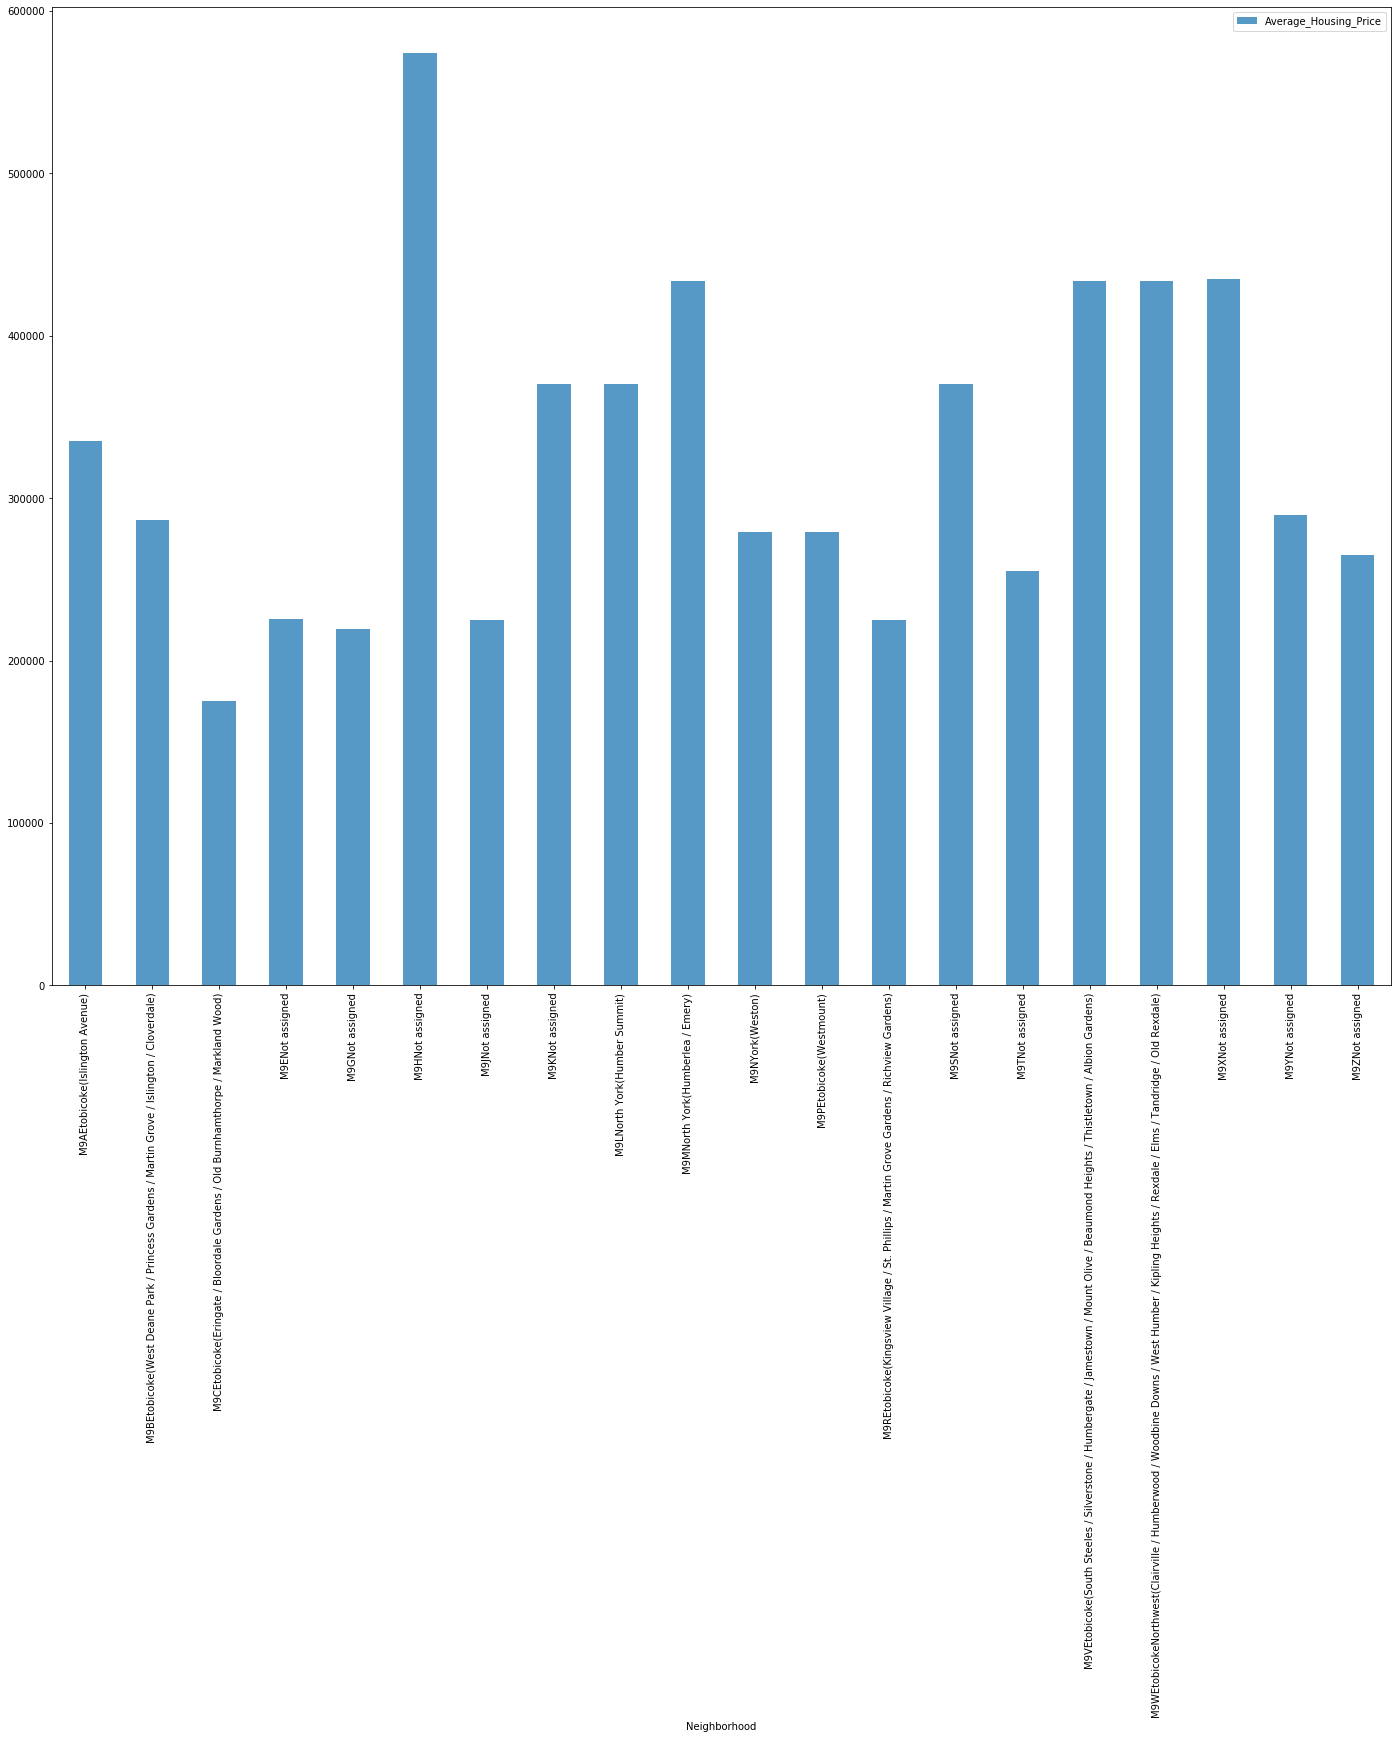

In [56]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [57]:

clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [61]:

new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8
                                                           ]})

In [62]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

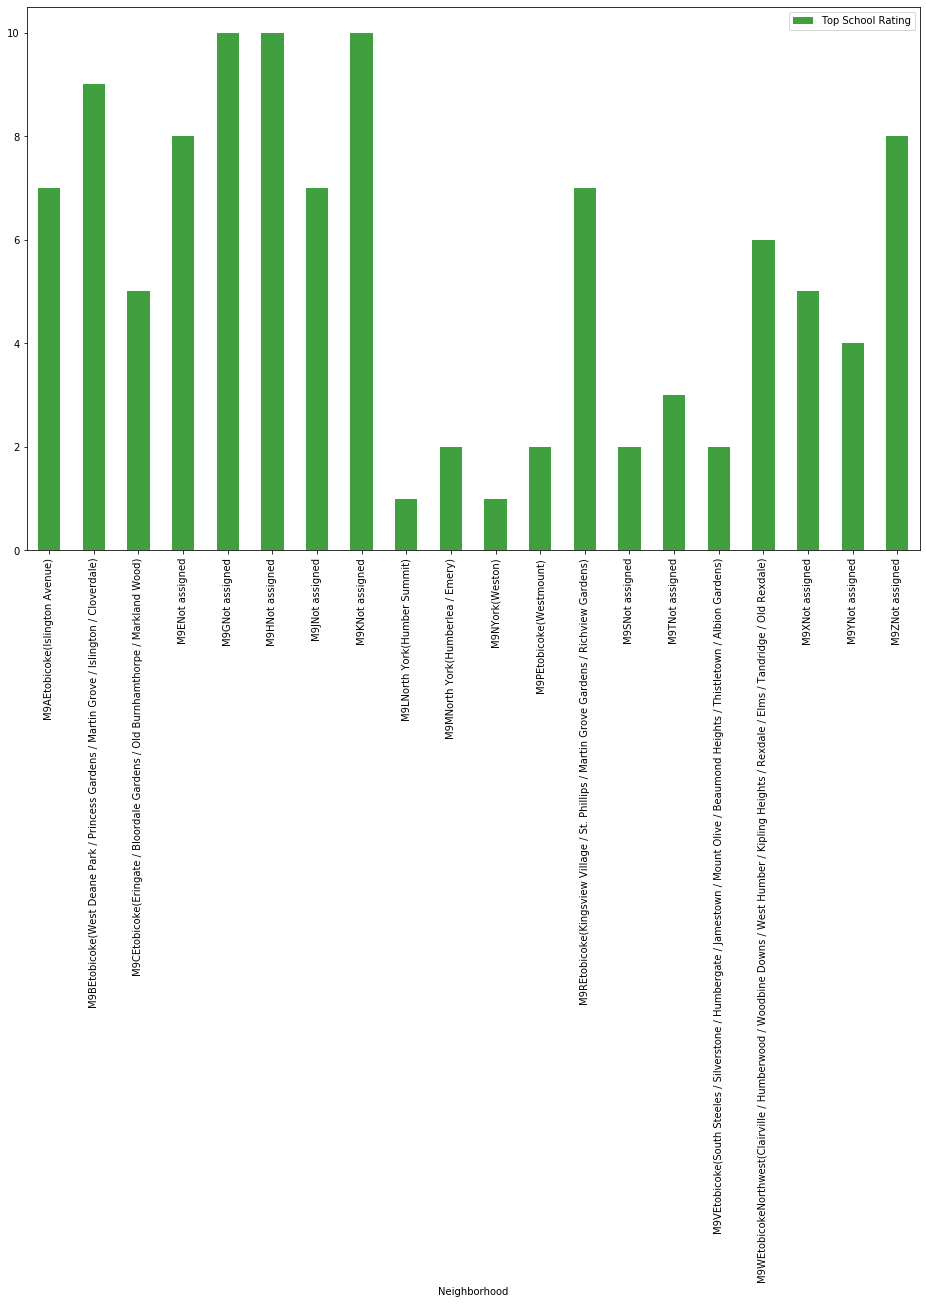

In [63]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);